# Find duplicate images in large datasets efficiently

In [1]:
from pathlib import Path
from pprint import pprint as _pprint
def pprint(data): (_pprint(data, sort_dicts=False))
import os
import copy
import json
from PIL import Image
import imagehash
from tqdm.notebook import tqdm
from img_utils import show_images
import shutil
from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map
from img_utils import average_hash_mp
from img_utils import average_hash_mp_o

## Find duplicates
Check and assert duplicates. A higher hash size equals a smaller likelihood to find false positives. Duplicate pictures are usually not exactly the same. Therefore, an average hash is used. A hash size of 32 seems to be a good value to find duplicates (different scales, bitrate, ...) without getting too many false positives. Probably needs to be higher if dataset contains subsequent video frames and not independent images.

In [2]:
IMG_DIR = '/Users/john/datasets/coco/images/train2017'
HASH_SIZE = 32
MULTIPROCESSING = True

def find_duplicates(image_dir:str, hash_size:int=32):
    """
    Find duplicate images based on average hash. Returns dict with candidates.
    """
    fnames = [name for name in Path(image_dir).glob("**/*.jpg")]
    hashes, duplicates, seen, dup, count = [], {}, set(), set(), 0
    if MULTIPROCESSING:
        with Pool() as p:
            packages = [(name, hash_size) for name in fnames]
            hashes = process_map(average_hash_mp, packages, chunksize=10, desc="hashing")
    else:
        pbar = tqdm(fnames)  
        pbar.set_description('hashing')
        for image in pbar:
            with Image.open(image) as img:
                _hash = imagehash.average_hash(img, hash_size)
                hashes.append([_hash, image])
    i, total = 0, len(hashes)
    pbar = tqdm([hashed[0] for hashed in hashes])
    pbar.set_description('search...')
    for _hash in pbar:
        if _hash not in seen:
            seen.add(_hash)
        else:
            dup.add(_hash)
    for (_hash, image) in hashes:
        if _hash in dup:
            if _hash in duplicates:
                duplicates[_hash].append(str(image))
                count += 1
            else:
                duplicates[_hash] = [str(image)]
    print(f'duplicates: {count}')
    return {i:v for i, (_, v) in enumerate(duplicates.items())}

result = find_duplicates(IMG_DIR, HASH_SIZE)


hashing:   0%|          | 0/118287 [00:00<?, ?it/s]

  0%|          | 0/118287 [00:00<?, ?it/s]

duplicates: 25


## Inspect and exclude false positives
Hint: adjust KEYS and slice in top of next cell

Duplicates: 23 / Dataset: 118287 / Dup. percentage: 0.02 %




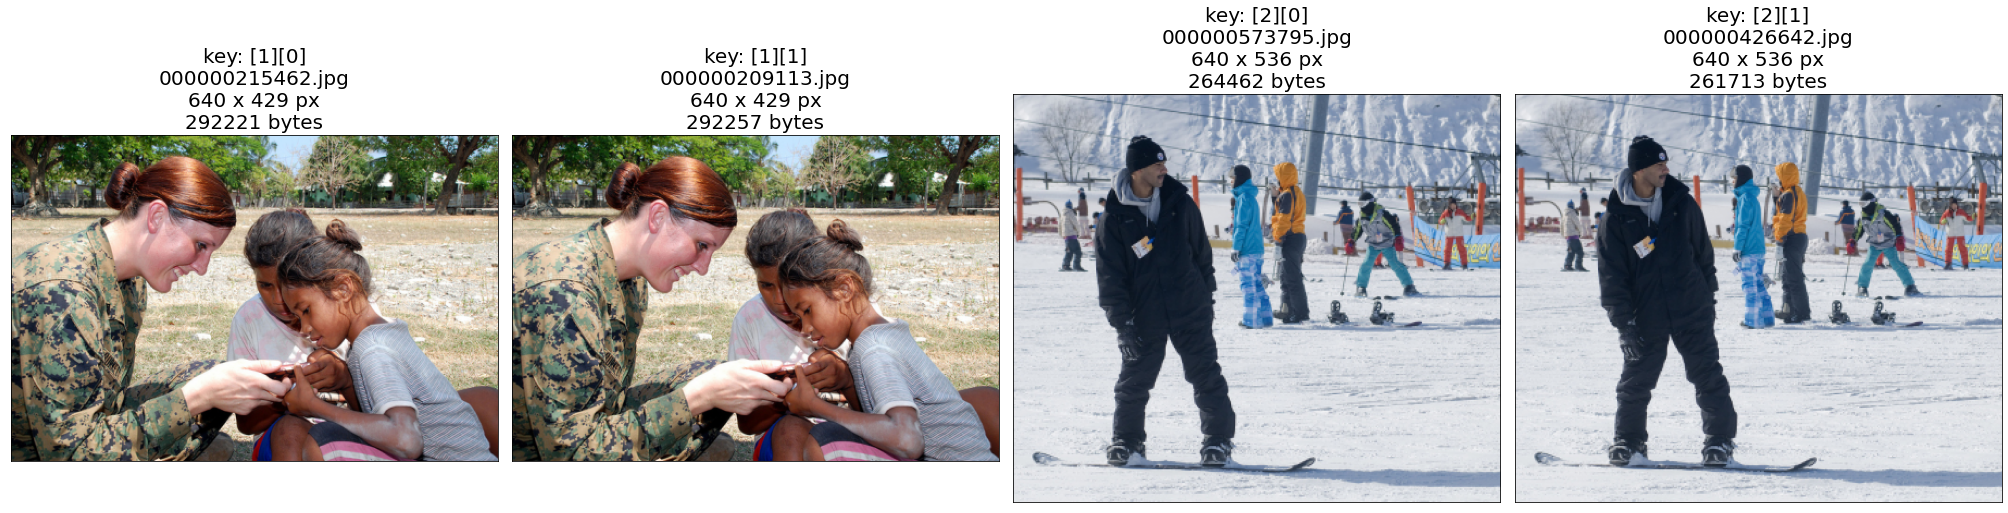

In [8]:
# Remove false positives manually
# Insert index / slice here
KEYS = [ 0, 17 ]

final = result.copy()
for e in KEYS:
    final.pop(e)
final_slice = dict(list(final.items())[0:2]).copy()  # inspect SLICE if output is too large
    
    
def img_label(result):
    images = []
    labels = []
    for i, entries in result.items():
        for j, image in enumerate(entries):
            images.append(image)
            img = Image.open(image) 
            width, height = img.size
            size = os.stat(image).st_size
            labels.append(f'key: [{i}][{j}]\n{Path(image).name}\n{width} x {height} px\n{size} bytes')
    return images, labels

# calc. final stats after inspection
num_dup = 0
for i, entries in final.items():
    for j, image in enumerate(entries):
        if j > 0:
            num_dup += 1
    
dataset_len = len([p for p in Path(IMG_DIR).glob("**/*.jpg")])
print(f'Duplicates: {num_dup} / Dataset: {dataset_len} / Dup. percentage: {num_dup/dataset_len*100:.2f} %\n\n')
images, labels = img_label(final_slice)
if len(images) > 0:
    show_images(images, labels, per_row=4, imsize=(7,7), resize=300, crop=False, font_size=20);

## Export

In [106]:
EXPORT_IMG = False  # copy image pairs for further inspection 
PATHS = False  # also export paths
EXPORT_TO = '/Users/john/datasets/dup/coco_oc'


def export(export_path:str, final_results:dict, dataset_len=dataset_len):
    """Export final results created above.
    """
    r = final_results
    num_dup = 0
    for i, entries in r.items():
        for j, image in enumerate(entries):
            if j > 0:
                num_dup += 1
    info = {
        'dataset': str(Path(list(r.values())[0][0]).parent),
        'duplicates': num_dup,
        'dataset_len': dataset_len,
        'dup_percentage': num_dup/dataset_len*100
    }
    image_pairs = [[str(Path(path).name) for path in v] for k, v in r.items()]
    path_pairs = [[str(path) for path in v] for k, v in r.items()]
    
    export = {
        'info': info,
        'image_pairs': image_pairs,
        'path_pairs': path_pairs
    }
    if not PATHS:
        export.pop('path_pairs')
    
    os.makedirs(export_path, exist_ok=True)
    # json
    with open(Path(export_path, 'export.json'), 'w', encoding='utf-8') as f:
        json.dump(export, f, ensure_ascii=False, indent=4)
    # image pairs as .txt only
    with open(Path(export_path, 'export.txt'), 'w', encoding='utf-8') as f:
        f.writelines(f'INFO:\n')
        for k, v in export['info'].items():
            f.writelines(f'    {k}: {v}\n')
        f.writelines(f'\nIMAGE PAIRS:\n')
        for pair in export['image_pairs']:
            f.writelines(f'    ')
            for img in pair:
                f.writelines(f'{img} ')
            f.writelines(f'\n')
                
    if EXPORT_IMG:
        img_path = Path(export_path) / Path('img_export')
        os.makedirs(img_path, exist_ok=True)
        for i, entries in r.items():
            for image in entries:
                destination = Path(img_path, f'{i}_{Path(image).name}')
                shutil.copy(image, destination)

export(EXPORT_TO, final)

# Find overlap (duplicate images between datasets)
Modification of the workflow above with multiple datasets as input. \
Helpful for checking train/val/test sets or for dataset merging.


### info all datasets:
**num_duplicates_total**: number of images that have to be deleted to get a unique dataset, if all datasets are combined \
**num_duplicates_self_total**: number of images that have to be deleted in seperate dataset, to have unique datasets \
**num_overlap_total**: number of images that have to be deleted to not have dataset overlap \
**dup_percentage_total**: num_duplicates_total / images in all datasets * 100 \
**dup_percentage_overlap**: num_overlap_total / images all datasets * 100
### info indiviual dataset:
**duplicates_self**: number of images that have to be deleted in this dataset to make it unique \
**duplicates_overlap**: number of images that have to be deleted in this dataset to not overlap with the other \
**duplicates_total**: duplicates_self + duplicates_overlap \
**dup_percentage_self**: duplicates_self / images in this dataset * 100 \
**dup_percentage_overlap**: duplicates_overlap / images in this dataset * 100

In [43]:
DATASETS = {
    'train2017': '/Users/john/datasets/coco/images/train2017',
    'val2017': '/Users/john/datasets/coco/images/val2017',
    'test2017': '/Users/john/datasets/coco/images/test2017'
}
# DATASETS = {
#     'crowdpose': '/Users/john/datasets/crowd_pose/images',
#     'mpii': '/Users/john/datasets/mp2/images',
#     'ochuman': '/Users/john/datasets/ochuman/images'
# }

HASH_SIZE = 32
MULTIPROCESSING = True

def find_overlap(datasets:dict={'dataset_name': '/dataset/dir'}, hash_size:int=32):
    """
    Find duplicate images based on average hash; over several datasets. Returns dict with candidates and dataset overlap.
    """
    files = []
    for dataset, path in datasets.items():
        files += [(dataset, path) for path in Path(path).glob("**/*.jpg")]
    hashes, duplicates, seen, dup = [], {}, set(), set()
    count_total, count_overlap = 0, 0
    last_dup_1, last_dup_2 = None, None
    if MULTIPROCESSING:
        with Pool() as p:
            packages = [((dataset, path), hash_size) for (dataset, path) in files]
            hashes = process_map(average_hash_mp_o, packages, chunksize=10, desc="hashing")
    else:
        pbar = tqdm(files)  
        pbar.set_description('hashing')
        for (dataset, path) in pbar:
            with Image.open(path) as img:
                _hash = imagehash.average_hash(img, hash_size)
                hashes.append([_hash, dataset, path])
    pbar = tqdm([hashed[0] for hashed in hashes])
    pbar.set_description('search...')
    for _hash in pbar:
        if _hash not in seen:
            seen.add(_hash)
        else:
            dup.add(_hash)
    for (_hash, dataset, path) in hashes:
        if _hash in dup:
            if _hash in duplicates:
                duplicates[_hash].append((dataset, str(path)))
                count_total += 1
            else:
                duplicates[_hash] = [(dataset, str(path))]
    for _hash in duplicates:
        if len(set([dataset for (dataset, path) in duplicates[_hash]])) > 1:  # set of datasets from a duplicate
            count_overlap += len([dataset for (dataset, path) in duplicates[_hash]]) - 1  # count duplicates as overlap
            last_dup_1 = duplicates[_hash][-2][0]
            last_dup_2 = duplicates[_hash][-1][0]
    print(f'duplicates: {count_total} –> overlap: {count_overlap} ::last {last_dup_1}-{last_dup_2}')
    return {i:v for i, (_, v) in enumerate(duplicates.items())}

resultx = find_overlap(DATASETS, HASH_SIZE)

hashing:   0%|          | 0/163957 [00:00<?, ?it/s]

  0%|          | 0/163957 [00:00<?, ?it/s]

duplicates: 36 –> overlap: 12 ::last val2017-test2017


### Remove false positives manually
Hint: adjust KEYS and slice in top of next cell

Duplicates: 32 -> Overlap: 8 / Dup. percentage: 0.02 %


OVERLAP_ONLY=True



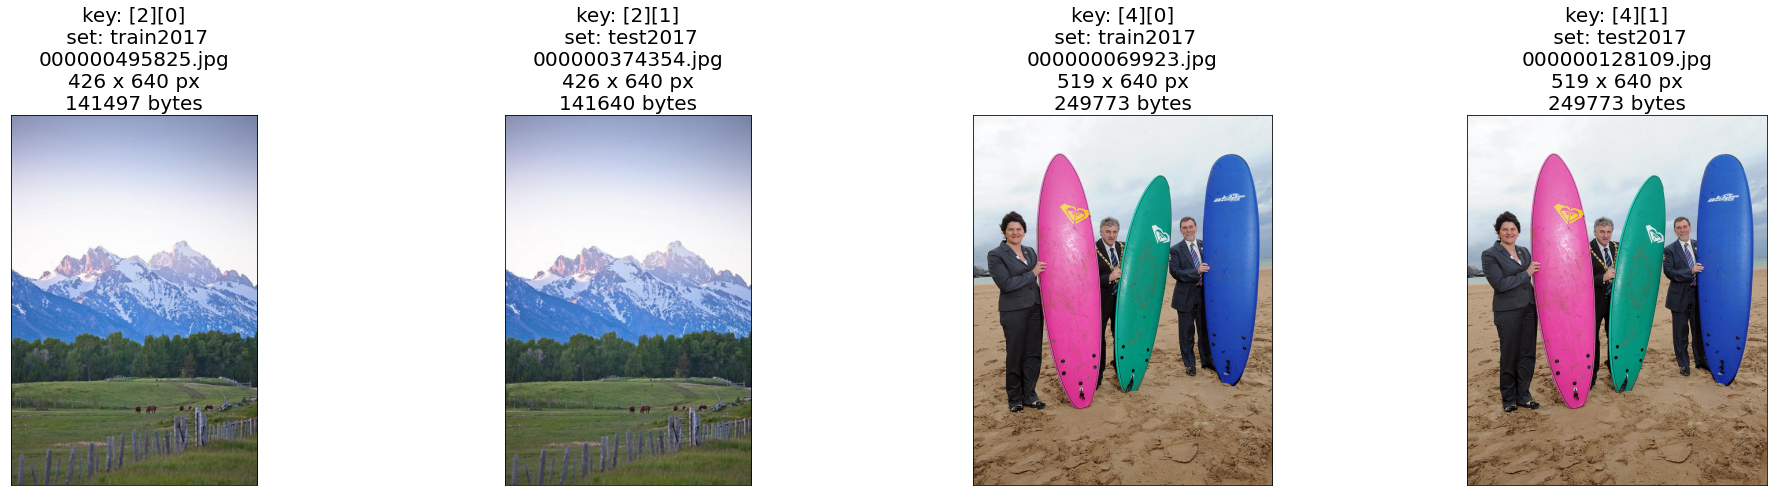

In [46]:
KEYS = [ 0, 22 ] # insert index of false postive here
OVERLAP_ONLY = True  # only inspect overlap

final = copy.deepcopy(resultx)
for e in KEYS:
    final.pop(e)
final_slice = dict(list(final.items())[:4]).copy()  # inspect SLICE if output is too large

    
def img_label(result):
    images = []
    labels = []
    for i, entries in result.items():
        for j, (dataset, image) in enumerate(entries):
            images.append(image)
            img = Image.open(image) 
            width, height = img.size
            size = os.stat(image).st_size
            labels.append(f'key: [{i}][{j}]\n set: {dataset}\n{Path(image).name}\n{width} x {height} px\n{size} bytes')
    return images, labels

# calc. final stats after inspection
num_dup = 0
num_overlap = 0
for i, entry in final.items():
    datasets = [dataset for (dataset, path) in entry]
    num_dup += len(datasets) - 1
    if len(set(datasets)) > 1:
        num_overlap += len(datasets) - 1

combined_len = 0
for _, img_dir in DATASETS.items():
    combined_len += len([n for n in Path(img_dir).glob("*.jpg")])
print(f'Duplicates: {num_dup} -> Overlap: {num_overlap} / Dup. percentage: {num_dup/combined_len*100:.2f} %\n\n')
if OVERLAP_ONLY:
    print(f'{OVERLAP_ONLY=}\n')
    temp_slice = final_slice.copy()
    for idx, entry in temp_slice.items():
        dataset_pairs = set()
        for pair in entry:
            dataset_pairs.add(pair[0])
        if len(dataset_pairs) < 2:
            final_slice.pop(idx)
images, labels = img_label(final_slice)
if len(images) > 0:
    show_images(images, labels, per_row=4, imsize=(7,7), crop=False, resize=300, font_size=20);

## Export

In [515]:
EXPORT_IMG = False # copy image pairs for further inspection 
PATHS = True  # export paths
EXPORT_TO = '/Users/john/datasets/dup/coco'


def export(export_path:str, final_results:dict, datasets:dict=DATASETS):
    """Export final results created above.
    """
    results = [entry for entry in final_results.values()]
    num_dup = 0
    num_overlap = 0
    dup = {}
    overlap = {}
    count = {}
    
    # total counts
    num_dup_total = 0
    num_overlap_total = 0
    for i, entry in final_results.items():
        _datasets = [dataset for (dataset, path) in entry]
        num_dup_total += len(_datasets) - 1
        if len(set(_datasets)) > 1:
            num_overlap_total += len(_datasets) - 1
    
    # build info for each dataset
    for dataset in datasets:
        dup[dataset] = []
        overlap[dataset] = []
        count[dataset] = {}
        count_dup_self = 0
        dataset_overlap = []
        for dups in results:  # duplicates for one image
            image_pair = []  # list of pairs [img1, img2, ..
            image_pair_overlap = []  # list of lists of pairs [ [(set_self1, img_self1), (set_self2, img_self2), (set2, img3), (set2, img4), (set3, img3)], ..]
            len_self = len([_dataset for (_dataset, _) in dups if _dataset == dataset])  # duplicates self, no overlap
            unique = set([_dataset for (_dataset, _) in dups])  # datasets that share current duplicate image
            for _dataset, path in dups:
                if _dataset == dataset and len_self > 1:
                    image_pair.append(path)
                    if len(image_pair) > 1:
                        count_dup_self += 1
                if dataset in unique and len(unique) > 1:
                    image_pair_overlap.append((_dataset, path))
                    if _dataset == dataset:
                        dataset_overlap.append(path)
            if len(image_pair) > 0:
                dup[dataset].append(image_pair)
            if len(image_pair_overlap) > 0:
                overlap[dataset].append(image_pair_overlap)
            count[dataset]['dup_self'] = count_dup_self
            count[dataset]['overlap'] = len(set(dataset_overlap))
    dataset_info = {}
    num_images_total = 0
    num_duplicates_self_total = 0
    dataset_info['info'] = {}
    for dataset, path in datasets.items():
        # build
        image_pairs = [[str(Path(path).name) for path in paths] for paths in dup[dataset]]
        path_pairs = [[str(Path(path)) for path in paths] for paths in dup[dataset]]
        image_pairs_o = [[(dataset, str(Path(path).name)) for (dataset, path) in dups] for dups in overlap[dataset]]
        path_pairs_o = [[(dataset, str(Path(path))) for (dataset, path) in dups] for dups in overlap[dataset]]
        # sort (list current dataset first in overlap)
        image_pairs_o = ( 
            [[(_dataset, path) for (_dataset, path) in dups if _dataset == dataset]  # same dataset 
             + [(_dataset, path) for (_dataset, path) in dups if _dataset != dataset] for dups in image_pairs_o] )  # rest
        path_pairs_o = ( 
            [[(_dataset, path) for (_dataset, path) in dups if _dataset == dataset]  # same dataset 
             + [(_dataset, path) for (_dataset, path) in dups if _dataset != dataset] for dups in path_pairs_o] )  # rest
        num_images = len([image for image in Path(path).glob("**/*.jpg")])
        dataset_info[dataset] = {
            'dataset': dataset,
            'path': str(path),
            'images': num_images,
            'duplicates_self': count[dataset]['dup_self'],
            'duplicates_overlap': count[dataset]['overlap'],
            'duplicates_total': count[dataset]['dup_self'] + count[dataset]['overlap'],
            'dup_percentage_self': 0 if num_images == 0 else round(count[dataset]['dup_self']/num_images*100, 4),
            'dup_percentage_overlap': 0 if num_images == 0 else round(count[dataset]['overlap']/num_images*100, 4),
            'image_pairs': image_pairs,
            'path_pairs': path_pairs,
            'overlap': {'image_pairs': image_pairs_o, 'path_pairs': path_pairs_o}
        }
        num_images_total += num_images
        num_duplicates_self_total += count[dataset]['dup_self']
    dataset_info['info'] = {
        'num_datasets': len([i for dataset in dataset_info.values()]) - 1,
        'num_images': num_images_total,
        'num_duplicates_total':  num_dup_total,
        'num_duplicates_self_total': num_duplicates_self_total,
        'num_overlap_total':  num_overlap_total,
        'dup_percentage_total': 0 if num_images_total == 0 else round(num_dup_total/num_images_total*100, 4),
        'dup_percentage_overlap': 0 if num_images_total == 0 else round(num_overlap_total/num_images_total*100, 4),
    }
    export = copy.deepcopy(dataset_info)
    if not PATHS:
        for dataset in dataset_info:
            if dataset != 'info':
                dataset_info[dataset].pop('path')
                dataset_info[dataset].pop('path_pairs')
                dataset_info[dataset]['overlap'].pop('path_pairs')
    
    # Export
    os.makedirs(export_path, exist_ok=True)
    # json
    with open(Path(export_path, 'export.json'), 'w', encoding='utf-8') as f:
        json.dump(dataset_info, f, ensure_ascii=False, indent=4)
    # image pairs as .txt only
    with open(Path(export_path, 'export.txt'), 'w', encoding='utf-8') as f:
        f.writelines(f'INFO:\n')
        for k, v in dataset_info['info'].items():
            f.writelines(f'    {k}: {v}\n')
        f.writelines(f'\nIMAGE PAIRS:\n')
        for dataset in datasets:
            f.writelines(f"    {dataset}\n")
            f.writelines(f"        images: {dataset_info[dataset]['images']}\n")
            f.writelines(f"        duplicates_self: {dataset_info[dataset]['duplicates_self']}\n")
            f.writelines(f"        duplicates_overlap: {dataset_info[dataset]['duplicates_overlap']}\n")
            f.writelines(f"        duplicates_total: {dataset_info[dataset]['duplicates_total']}\n")
            f.writelines(f"        dup_percentage_self: {dataset_info[dataset]['dup_percentage_self']}\n")
            f.writelines(f"        dup_percentage_overlap: {dataset_info[dataset]['dup_percentage_overlap']}\n")
            f.writelines(f"        image_pairs:\n")
            for pair in dataset_info[dataset]['image_pairs']:
                f.writelines(f'            ')
                for img in pair:
                    f.writelines(f'{img} ')
                f.writelines(f'\n')
            f.writelines(f"        overlap_image_pairs:\n")
            for pair in dataset_info[dataset]['overlap']['image_pairs']:
                f.writelines(f'            ')
                for (_dataset, img) in pair:
                    f.writelines(f'{_dataset}-{img} ')
                f.writelines(f'\n')

    if EXPORT_IMG:
        img_path = Path(export_path) / Path('img_export')
        os.makedirs(img_path, exist_ok=True)
        for dataset in datasets:
            for i, pair in enumerate(export[dataset]['overlap']['path_pairs']):
                for (_dataset, path) in pair:
                    destination = Path(img_path, f'{i}_{_dataset}_{Path(path).name}')
                    shutil.copy(path, destination)
    
    # pprint(dataset_info)

export(EXPORT_TO, final)

# LOG

- COCO
    - train2017: 23 / 0.019 %
    - val2017: 0
    - test2017: 1 / 0.002 %
    - overlap:
        - train2017 / test2017: 6
        - train2017 / val2017: 0
        - test2017 / val2017: 2
- MPII:
    - all: 71 / 0.284 %
- CrowdPose:
    - all: 29 / 0.145 %
- OCHuman:
    - all: 43 / 0.856 %